In [1]:
library(DropletUtils)
library(scater)

sce.pbmc <- read10xCounts("/home/mowp/data/scRNA/pbmc4k/raw_gene_bc_matrices/GRCh38", col.names=TRUE)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bi

In [2]:
rownames(sce.pbmc) <- uniquifyFeatureNames(
    rowData(sce.pbmc)$ID, rowData(sce.pbmc)$Symbol)

library(EnsDb.Hsapiens.v86)
location <- mapIds(EnsDb.Hsapiens.v86, keys=rowData(sce.pbmc)$ID, 
    column="SEQNAME", keytype="GENEID")

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi



Loading required package: AnnotationFilter


Attaching package: 'ensembldb'


The following object is masked from 'package:stats':

    filter


Warning message:
"Unable to map 144 of 33694 requested IDs."


In [3]:
sce.pbmc

class: SingleCellExperiment 
dim: 33694 737280 
metadata(1): Samples
assays(1): counts
rownames(33694): RP11-34P13.3 FAM138A ... AC213203.1 FAM231B
rowData names(2): ID Symbol
colnames(737280): AAACCTGAGAAACCAT-1 AAACCTGAGAAACCGC-1 ...
  TTTGTCATCTTTAGTC-1 TTTGTCATCTTTCCTC-1
colData names(2): Sample Barcode
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [4]:
set.seed(100)
e.out <- emptyDrops(counts(sce.pbmc))
sce.pbmc <- sce.pbmc[,which(e.out$FDR <= 0.001)]

In [5]:
stats <- perCellQCMetrics(sce.pbmc, subsets=list(Mito=which(location=="MT")))
high.mito <- isOutlier(stats$subsets_Mito_percent, type="higher")
sce.pbmc <- sce.pbmc[,!high.mito]

In [6]:
library(scran)
set.seed(1000)
clusters <- quickCluster(sce.pbmc)
sce.pbmc <- computeSumFactors(sce.pbmc, cluster=clusters)
sce.pbmc <- logNormCounts(sce.pbmc)

In [7]:
set.seed(1001)
dec.pbmc <- modelGeneVarByPoisson(sce.pbmc)
top.pbmc <- getTopHVGs(dec.pbmc, prop=0.1)

In [8]:
set.seed(10000)
sce.pbmc <- denoisePCA(sce.pbmc, subset.row=top.pbmc, technical=dec.pbmc)

set.seed(100000)
sce.pbmc <- runTSNE(sce.pbmc, dimred="PCA")

set.seed(1000000)
sce.pbmc <- runUMAP(sce.pbmc, dimred="PCA")

In [9]:
g <- buildSNNGraph(sce.pbmc, k=10, use.dimred = 'PCA')
clust <- igraph::cluster_walktrap(g)$membership
colLabels(sce.pbmc) <- factor(clust)

In [10]:
sce.pbmc

class: SingleCellExperiment 
dim: 33694 3985 
metadata(1): Samples
assays(2): counts logcounts
rownames(33694): RP11-34P13.3 FAM138A ... AC213203.1 FAM231B
rowData names(2): ID Symbol
colnames(3985): AAACCTGAGAAGGCCT-1 AAACCTGAGACAGACC-1 ...
  TTTGTCAGTTAAGACA-1 TTTGTCATCCCAAGAT-1
colData names(4): Sample Barcode sizeFactor label
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):

The celldex contains a number of curated reference datasets, mostly assembled from bulk RNA-seq or microarray data of sorted cell types. These references are often good enough for most applications provided that they contain the cell types that are expected in the test population. Here, we will use a reference constructed from Blueprint and ENCODE data (Martens and Stunnenberg 2013; The ENCODE Project Consortium 2012); this is obtained by calling the `BlueprintEncode()` function to construct a SummarizedExperiment containing log-expression values with curated labels for each sample.

In [13]:
library(celldex)
ref <- BlueprintEncodeData()
ref

snapshotDate(): 2022-10-31

see ?celldex and browseVignettes('celldex') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache



class: SummarizedExperiment 
dim: 19859 259 
metadata(0):
assays(1): logcounts
rownames(19859): TSPAN6 TNMD ... LINC00550 GIMAP1-GIMAP5
rowData names(0):
colnames(259): mature.neutrophil
  CD14.positive..CD16.negative.classical.monocyte ...
  epithelial.cell.of.umbilical.artery.1
  dermis.lymphatic.vessel.endothelial.cell.1
colData names(3): label.main label.fine label.ont

We call the `SingleR()` function to annotate each of our PBMCs with the main cell type labels from the Blueprint/ENCODE reference. This returns a DataFrame where each row corresponds to a cell in the test dataset and contains its label assignments. Alternatively, we could use the labels in `ref$label.fine`, which provide more resolution at the cost of speed and increased ambiguity in the assignments.

In [19]:
levels(factor(ref$label.main))

[1] "Adipocytes"        "Astrocytes"        "B-cells"          
 [4] "CD4+ T-cells"      "CD8+ T-cells"      "Chondrocytes"     
 [7] "DC"                "Endothelial cells" "Eosinophils"      
[10] "Epithelial cells"  "Erythrocytes"      "Fibroblasts"      
[13] "HSC"               "Keratinocytes"     "Macrophages"      
[16] "Melanocytes"       "Mesangial cells"   "Monocytes"        
[19] "Myocytes"          "Neurons"           "Neutrophils"      
[22] "NK cells"          "Pericytes"         "Skeletal muscle"  
[25] "Smooth muscle"

In [14]:
library(SingleR)
pred <- SingleR(test=sce.pbmc, ref=ref, labels=ref$label.main)
table(pred$labels)


Attaching package: 'SingleR'


The following objects are masked from 'package:celldex':

    BlueprintEncodeData, DatabaseImmuneCellExpressionData,
    HumanPrimaryCellAtlasData, ImmGenData, MonacoImmuneData,
    MouseRNAseqData, NovershternHematopoieticData


Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or 


     B-cells CD4+ T-cells CD8+ T-cells           DC  Eosinophils Erythrocytes 
         549          772         1275            1            1            6 
         HSC    Monocytes     NK cells 
          14         1116          251 

We inspect the results using a heatmap of the per-cell and label scores. Ideally, each cell should exhibit a high score in one label relative to all of the others, indicating that the assignment to that label was unambiguous. This is largely the case for monocytes and B cells, whereas we see more ambiguity between CD4+ and CD8+ T cells (and to a lesser extent, NK cells).

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


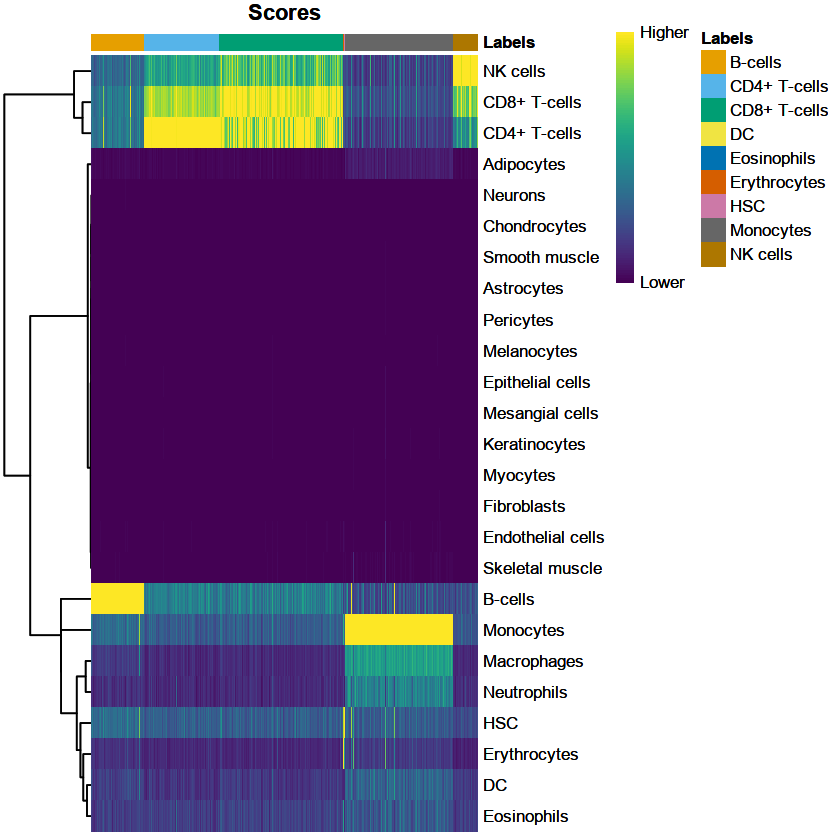

In [15]:
plotScoreHeatmap(pred)

We compare the assignments with the clustering results to determine the identity of each cluster. Here, several clusters are nested within the monocyte and B cell labels, indicating that the clustering represents finer subdivisions within the cell types. Interestingly, our clustering does not effectively distinguish between CD4+ and CD8+ T cell labels. This is probably due to the presence of other factors of heterogeneity within the T cell subpopulation (e.g., activation) that have a stronger influence on unsupervised methods than the a priori expected CD4+/CD8+ distinction.


我们将分配结果与聚类结果进行比较，以确定每个簇的身份。在这里，几个簇嵌套在单核细胞和B细胞标签中，表明聚类代表了细胞类型内部的更细分区域。有趣的是，我们的聚类不能有效地区分CD4 +和CD8 + T细胞标签。这可能是由于T细胞亚群内存在其他异质性因素（例如激活），这些因素对无监督方法具有比先验预期的CD4 + / CD8 +区别更强的影响。

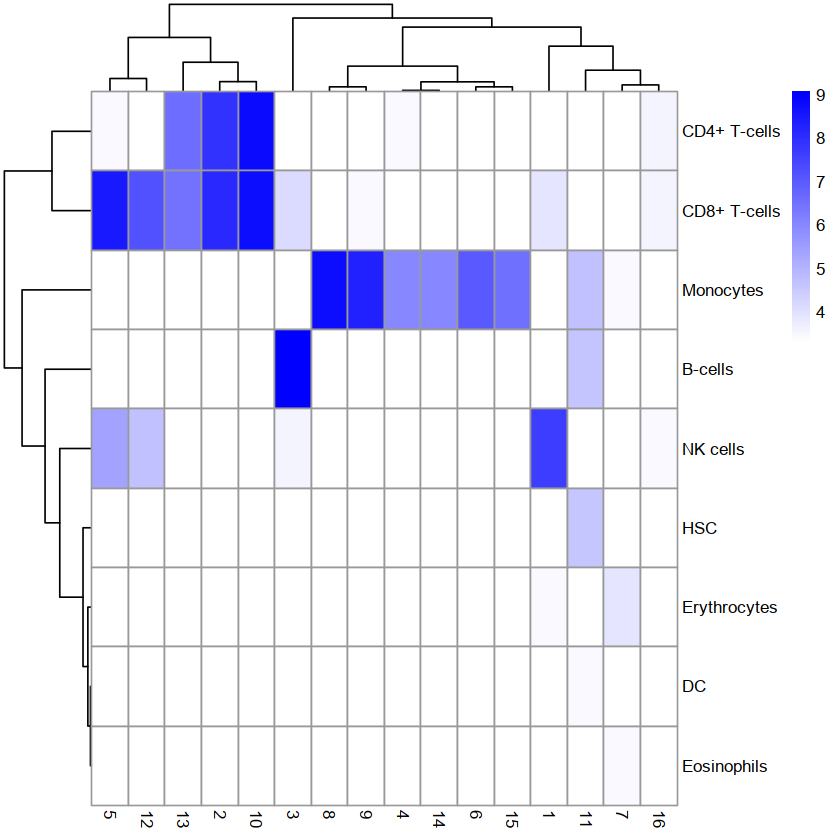

In [16]:
tab <- table(Assigned=pred$pruned.labels, Cluster=colLabels(sce.pbmc))

# Adding a pseudo-count of 10 to avoid strong color jumps with just 1 cell.
library(pheatmap)
pheatmap(log2(tab+10), color=colorRampPalette(c("white", "blue"))(101))

This episode highlights some of the differences between reference-based annotation and unsupervised clustering. The former explicitly focuses on aspects of the data that are known to be interesting, simplifying the process of biological interpretation. However, the cost is that the downstream analysis is restricted by the diversity and resolution of the available labels, a problem that is largely avoided by de novo identification of clusters. We suggest applying both strategies to examine the agreement (or lack thereof) between reference label and cluster assignments. Any inconsistencies are not necessarily problematic due to the conceptual differences between the two approaches; indeed, one could use those discrepancies as the basis for further investigation to discover novel factors of variation in the data.

本节介绍了基于参考注释和无监督聚类之间的一些差异。前者明确关注已知的有趣数据方面，简化了生物解释的过程。然而，代价是下游分析受到可用标签的多样性和分辨率的限制，这在de novo聚类中很大程度上得到了避免。我们建议应用两种策略来检查参考标签和聚类分配之间的一致性（或缺乏一致性）。由于两种方法之间的概念差异，任何不一致都不一定是问题；事实上，可以将这些差异用作进一步研究的基础，以发现数据中的新变异因素

# Assigning cell labels from gene sets

In [1]:
library(scRNAseq)
sce.zeisel <- ZeiselBrainData()

library(scater)
sce.zeisel <- aggregateAcrossFeatures(sce.zeisel, 
    id=sub("_loc[0-9]+$", "", rownames(sce.zeisel)))

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [4]:
library(org.Mm.eg.db)
rowData(sce.zeisel)$Ensembl <- mapIds(org.Mm.eg.db, 
    keys=rownames(sce.zeisel), keytype="SYMBOL", column="ENSEMBL")

Loading required package: AnnotationDbi





'select()' returned 1:many mapping between keys and columns



In [5]:
stats <- perCellQCMetrics(sce.zeisel, subsets=list(
    Mt=rowData(sce.zeisel)$featureType=="mito"))
qc <- quickPerCellQC(stats, percent_subsets=c("altexps_ERCC_percent", 
    "subsets_Mt_percent"))
sce.zeisel <- sce.zeisel[,!qc$discard]


set.seed(1000)
clusters <- quickCluster(sce.zeisel)
sce.zeisel <- computeSumFactors(sce.zeisel, cluster=clusters) 
sce.zeisel <- logNormCounts(sce.zeisel)

In [6]:
library(scran)

# get marker gene from annotated single cell dataset
wilcox.z <- pairwiseWilcox(sce.zeisel, sce.zeisel$level1class, 
    lfc=1, direction="up")
markers.z <- getTopMarkers(wilcox.z$statistics, wilcox.z$pairs,
    pairwise=FALSE, n=50)
lengths(markers.z)

astrocytes_ependymal    endothelial-mural         interneurons 
                  79                   83                  118 
           microglia     oligodendrocytes        pyramidal CA1 
                  69                   81                  125 
        pyramidal SS 
                 149

In [11]:
# marker gene list
str(markers.z)

Formal class 'SimpleList' [package "S4Vectors"] with 4 slots
  ..@ listData       :List of 7
  .. ..$ astrocytes_ependymal: chr [1:79] "Apoe" "Clu" "Gja1" "Gpr37l1" ...
  .. ..$ endothelial-mural   : chr [1:83] "Esam" "Sparc" "Sparcl1" "Epas1" ...
  .. ..$ interneurons        : chr [1:118] "Gad1" "Gad2" "Mllt11" "Ndrg4" ...
  .. ..$ microglia           : chr [1:69] "C1qa" "C1qb" "Csf1r" "Ctss" ...
  .. ..$ oligodendrocytes    : chr [1:81] "Cnp" "Mbp" "Mobp" "Plp1" ...
  .. ..$ pyramidal CA1       : chr [1:125] "Crym" "Gria1" "Hpca" "Neurod6" ...
  .. ..$ pyramidal SS        : chr [1:149] "Mef2c" "Nrgn" "Pcsk2" "Ncald" ...
  ..@ elementType    : chr "ANY"
  ..@ elementMetadata: NULL
  ..@ metadata       : list()


In [12]:
# test data

sce.tasic <- TasicBrainData()
sce.tasic

snapshotDate(): 2022-10-31

see ?scRNAseq and browseVignettes('scRNAseq') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?scRNAseq and browseVignettes('scRNAseq') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

snapshotDate(): 2022-10-31

see ?scRNAseq and browseVignettes('scRNAseq') for documentation

loading from cache



class: SingleCellExperiment 
dim: 24058 1809 
metadata(0):
assays(1): counts
rownames(24058): 0610005C13Rik 0610007C21Rik ... mt_X57780 tdTomato
rowData names(0):
colnames(1809): Calb2_tdTpositive_cell_1 Calb2_tdTpositive_cell_2 ...
  Rbp4_CTX_250ng_2 Trib2_CTX_250ng_1
colData names(13): sample_title mouse_line ... secondary_type
  aibs_vignette_id
reducedDimNames(0):
mainExpName: endogenous
altExpNames(1): ERCC

We use the `AUCell` package to identify marker sets that are highly expressed in each cell. This method ranks genes by their expression values within each cell and constructs a response curve of the number of genes from each marker set that are present with increasing rank. It then computes the area under the curve (AUC) for each marker set, quantifying the enrichment of those markers among the most highly expressed genes in that cell. This is roughly similar to performing a Wilcoxon rank sum test between genes in and outside of the set, but involving only the top ranking genes by expression in each cell.

In [13]:
library(GSEABase)
all.sets <- lapply(names(markers.z), function(x) {
    GeneSet(markers.z[[x]], setName=x)        
})
all.sets <- GeneSetCollection(all.sets)

library(AUCell)
rankings <- AUCell_buildRankings(counts(sce.tasic),
    plotStats=FALSE, verbose=FALSE)
cell.aucs <- AUCell_calcAUC(all.sets, rankings)
results <- t(assay(cell.aucs))
head(results)

Loading required package: annotate

Loading required package: XML

Loading required package: graph


Attaching package: 'graph'


The following object is masked from 'package:XML':

    addNode


Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Genes in the gene sets NOT available in the dataset: 
	endothelial-mural: 	7 (8% of 83)
	interneurons: 	1 (1% of 118)
	oligodendrocytes: 	2 (2% of 81)
	pyramidal CA1: 	4 (3% of 125)
	pyramidal SS: 	4 (3% of 149)



,astrocytes_ependymal,endothelial-mural,interneurons,microglia,oligodendrocytes,pyramidal CA1,pyramidal SS
Calb2_tdTpositive_cell_1,0.1386528,0.04264310,0.5306093,0.04845394,0.1317958,0.2317668,0.3476778
Calb2_tdTpositive_cell_2,0.1366283,0.04884635,0.4538357,0.02682648,0.1211293,0.2062570,0.2762466
Calb2_tdTpositive_cell_3,0.1087323,0.07269892,0.3459073,0.03583482,0.1567204,0.3218726,0.5244553
Calb2_tdTpositive_cell_4,0.1321658,0.04993108,0.5112665,0.05387632,0.1480893,0.2546714,0.3505890
Calb2_tdTpositive_cell_5,0.1512892,0.07161420,0.4929771,0.06655747,0.1385766,0.2088478,0.3009582
Calb2_tdTpositive_cell_6,0.1342012,0.09161375,0.3378310,0.03201310,0.1552946,0.4010508,0.5392798


In [15]:
rankings

Ranking for 24058 genes (rows) and 1809 cells (columns).

Top-left corner of the ranking:
               cells
genes           Calb2_tdTpositive_cell_1 Calb2_tdTpositive_cell_2
  0610005C13Rik                    21917                     8811
  0610007C21Rik                     2490                      503
  0610007L01Rik                     6537                     2511
  0610007N19Rik                    14099                    14212
  0610007P08Rik                    12157                     7898
  0610007P14Rik                    21059                     1488
               cells
genes           Calb2_tdTpositive_cell_3 Calb2_tdTpositive_cell_4
  0610005C13Rik                     7849                     8828
  0610007C21Rik                     1629                     1629
  0610007L01Rik                    22152                     8114
  0610007N19Rik                     9123                     9521
  0610007P08Rik                     8060                     9623
  0610007P

We assign cell type identity to each cell in the test dataset by taking the marker set with the top AUC as the label for that cell. Our new labels mostly agree with the original annotation from Tasic et al. (2016), which is encouraging. The only exception involves misassignment of oligodendrocyte precursors to astrocytes, which may be understandable given that they are derived from a common lineage. In the absence of prior annotation, a more general diagnostic check is to compare the assigned labels to cluster identities, under the expectation that most cells of a single cluster would have the same label (or, if multiple labels are present, they should at least represent closely related cell states).

In [16]:
new.labels <- colnames(results)[max.col(results)]
tab <- table(new.labels, sce.tasic$broad_type)
tab

                      
new.labels             Astrocyte Endothelial Cell GABA-ergic Neuron
  astrocytes_ependymal        43                2                 0
  endothelial-mural            0               27                 0
  interneurons                 0                0               759
  microglia                    0                0                 0
  oligodendrocytes             0                0                 1
  pyramidal SS                 0                0                 1
                      
new.labels             Glutamatergic Neuron Microglia Oligodendrocyte
  astrocytes_ependymal                    0         0               0
  endothelial-mural                       0         0               0
  interneurons                            2         0               0
  microglia                               0        22               0
  oligodendrocytes                        0         0              38
  pyramidal SS                          810         0     

As a diagnostic measure, we examine the distribution of AUCs across cells for each label (Figure 7.4). In heterogeneous populations, the distribution for each label should be bimodal with one high-scoring peak containing cells of that cell type and a low-scoring peak containing cells of other types. The gap between these two peaks can be used to derive a threshold for whether a label is “active” for a particular cell. (In this case, we simply take the single highest-scoring label per cell as the labels should be mutually exclusive.) In populations where a particular cell type is expected, lack of clear bimodality for the corresponding label may indicate that its gene set is not sufficiently informative.

,threshold,nCells
Global_k1,0.2156580,94
L_k2,0.2187282,94
R_k3,0.5804666,43
,threshold,nCells
Global_k1,0.1195260,114
L_k2,0.1617232,56
R_k3,0.2794018,26
,threshold,nCells
Global_k1,0.4741698,483
L_k2,0.2145179,1644


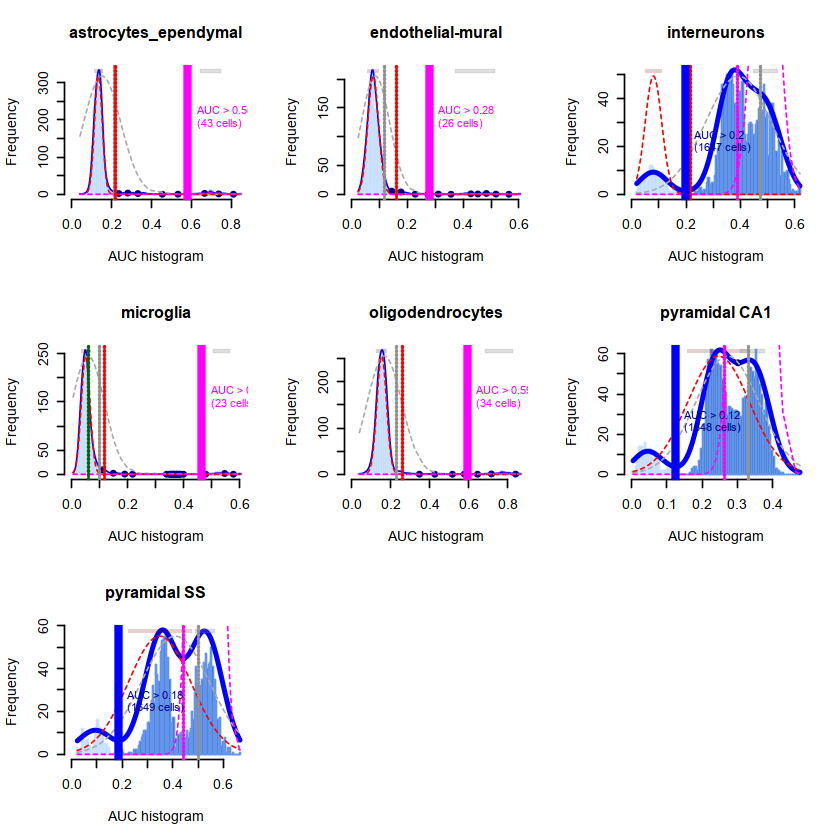

In [17]:
par(mfrow=c(3,3))
AUCell_exploreThresholds(cell.aucs, plotHist=TRUE, assign=TRUE) 

Distribution of AUCs in the Tasic brain dataset for each label in the Zeisel dataset. The blue curve represents the density estimate, the red curve represents a fitted two-component mixture of normals, the pink curve represents a fitted three-component mixture, and the grey curve represents a fitted normal distribution. Vertical lines represent threshold estimates corresponding to each estimate of the distribution.